In [1]:
import DirectDmTargets as dddm

calculating effective efficiency for Xe detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Ge detector done


In [2]:
import wimprates as wr
assert wr.__version__ !='0.2.2'
wr.__version__

'0.3.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

In [7]:
import pandas as pd

In [8]:
import scipy

In [9]:
import emcee
emcee.__version__

'3.0.0'

In [10]:
import corner

In [11]:
import time

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

# Emcee #
<https://emcee.readthedocs.io/en/stable/tutorials/quickstart/>

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [12]:
stats = dddm.MCMCStatModel("Xe")

stat_model::initialized for Xe detector. See print(stat_model) for default settings


In [13]:
stats.check_spectrum()

,counts,bin_centers,bin_left,bin_right
0,2207.621682,5.0,0.0,10.0
1,16702.199904,15.0,10.0,20.0
2,6748.536066,25.0,20.0,30.0
3,2238.784316,35.0,30.0,40.0
4,685.145347,45.0,40.0,50.0
5,190.030946,55.0,50.0,60.0
6,46.156533,65.0,60.0,70.0
7,9.171224,75.0,70.0,80.0
8,1.288080,85.0,80.0,90.0
9,0.097619,95.0,90.0,100.0


In [16]:
stats.config['prior']

{'log_mass': {'range': [0.1, 3],
  'prior_type': 'flat',
  'param': [0.1, 3],
  'dist': <function DirectDmTargets.statistics.get_priors.<locals>.<lambda>(x)>},
 'log_cross_section': {'range': [-46, -42],
  'prior_type': 'flat',
  'param': [-46, -42],
  'dist': <function DirectDmTargets.statistics.get_priors.<locals>.<lambda>(x)>},
 'density': {'range': [0.001, 0.9],
  'prior_type': 'gauss',
  'mean': 0.4,
  'std': 0.1,
  'param': (0.4, 0.1),
  'dist': <function DirectDmTargets.statistics.get_priors.<locals>.<lambda>(x)>},
 'v_0': {'range': [80, 380],
  'prior_type': 'gauss',
  'mean': 230,
  'std': 30,
  'param': (230, 30),
  'dist': <function DirectDmTargets.statistics.get_priors.<locals>.<lambda>(x)>},
 'v_esc': {'range': [379, 709],
  'prior_type': 'gauss',
  'mean': 544,
  'std': 33,
  'param': (544, 33),
  'dist': <function DirectDmTargets.statistics.get_priors.<locals>.<lambda>(x)>},
 'k': {'range': [0.5, 3.5],
  'prior_type': 'flat',
  'param': [0.5, 3.5],
  'dist': <function Di

In [17]:
def get_SHMpp_priors():
    """

    :return: dictionary of priors, type and values
    """
    priors = \
        {
        'log_mass':
            {'range': [0.1, 3], 'prior_type': 'flat'},
        'log_cross_section':
            {'range': [-46, -42], 'prior_type': 'flat'},
        'density':
            {'range': [0.001, 0.9], 'prior_type': 'gauss', 'mean': 0.55,
             'std': 0.17},
        'v_0':
            {'range': [80, 380], 'prior_type': 'gauss', 'mean': 230,
             'std': 3},
        'v_esc':
            {'range': [379, 709], 'prior_type': 'gauss', 'mean': 528,
             'std': 24.5},
        'k':
            {'range': [0.5, 3.5], 'prior_type': 'flat'}
        }
    for key in priors.keys():
        param = priors[key]
        if param['prior_type'] == 'flat':
            param['param'] = param['range']
            param['dist'] = lambda x: dddm.flat_prior(x)
        elif param['prior_type'] == 'gauss':
            param['param'] = param['mean'], param['std']
            param['dist'] = lambda x: dddm.gaus_prior(x)
    return priors

In [20]:
stats.config['prior'] = get_SHMpp_priors()

In [21]:
stats.config['prior']

{'log_mass': {'range': [0.1, 3],
  'prior_type': 'flat',
  'param': [0.1, 3],
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'log_cross_section': {'range': [-46, -42],
  'prior_type': 'flat',
  'param': [-46, -42],
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'density': {'range': [0.001, 0.9],
  'prior_type': 'gauss',
  'mean': 0.55,
  'std': 0.17,
  'param': (0.55, 0.17),
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'v_0': {'range': [80, 380],
  'prior_type': 'gauss',
  'mean': 230,
  'std': 3,
  'param': (230, 3),
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'v_esc': {'range': [379, 709],
  'prior_type': 'gauss',
  'mean': 528,
  'std': 24.5,
  'param': (528, 24.5),
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'k': {'range': [0.5, 3.5],
  'prior_type': 'flat',
  'param': [0.5, 3.5],
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>}}

In [41]:
for key in ['v_0', 'v_esc', 'rho_0']:
    if key == 'rho_0':
        key_prior = 'density'
    else:
        key_prior = key
    stats.config[key] = stats.config['prior'][key_prior]['mean']

In [22]:
stats.nwalkers = 250
stats.nsteps = 250
stats.log

{'sampler': False, 'did_run': False, 'pos': False}

In [23]:
start = time.time()
stats.run_emcee()
end = time.time()

C:\Users\Joran\programming\Anaconda3\envs\DD_DM\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:50:33<00:00, 26.53s/it]


In [24]:
end-start

6653.521779298782

In [25]:
assert stats.log['did_run']

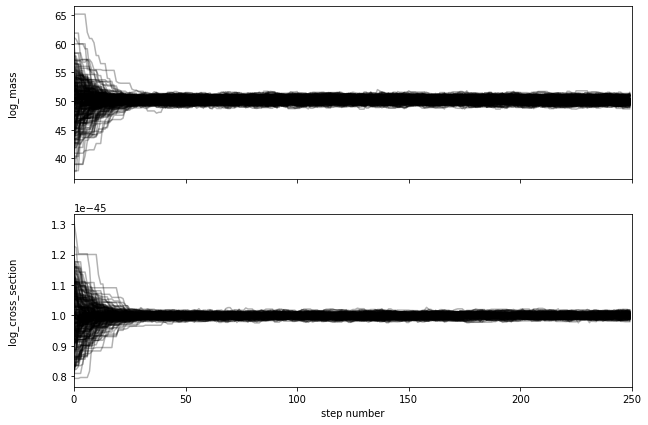

In [26]:
stats.show_walkers()

Removing a fraction of 0.2 of the samples
(3250, 2)


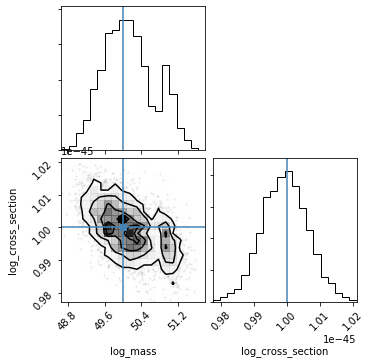

In [27]:
stats.show_corner()

## Full dimensionality ##

In [42]:
stats_full = dddm.MCMCStatModel("Xe")

stat_model::initialized for Xe detector. See print(stat_model) for default settings


In [43]:
stats_full.config['prior'] = get_SHMpp_priors()
stats_full.config['prior']

{'log_mass': {'range': [0.1, 3],
  'prior_type': 'flat',
  'param': [0.1, 3],
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'log_cross_section': {'range': [-46, -42],
  'prior_type': 'flat',
  'param': [-46, -42],
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'density': {'range': [0.001, 0.9],
  'prior_type': 'gauss',
  'mean': 0.55,
  'std': 0.17,
  'param': (0.55, 0.17),
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'v_0': {'range': [80, 380],
  'prior_type': 'gauss',
  'mean': 230,
  'std': 3,
  'param': (230, 3),
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'v_esc': {'range': [379, 709],
  'prior_type': 'gauss',
  'mean': 528,
  'std': 24.5,
  'param': (528, 24.5),
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>},
 'k': {'range': [0.5, 3.5],
  'prior_type': 'flat',
  'param': [0.5, 3.5],
  'dist': <function __main__.get_SHMpp_priors.<locals>.<lambda>(x)>}}

In [44]:
stats_full.nwalkers = stats.nwalkers
stats_full.nsteps = stats.nsteps * 2
stats_full.log

{'sampler': False, 'did_run': False, 'pos': False}

In [45]:
stats_full.log

{'sampler': False, 'did_run': False, 'pos': False}

In [46]:
# for key in stats_full.log.keys():
#     stats_full.log[key] = False


In [47]:
stats_full.fit_parameters = stats_full.known_parameters

In [ ]:
start = time.time()
stats_full.run_emcee()
end = time.time()

  4%|███▏                                                                           | 20/500 [13:43<5:37:02, 42.13s/it]

In [ ]:
end-start

In [ ]:
assert stats.log['did_run']

In [ ]:
stats_full.show_walkers()

In [ ]:
stats_full.show_corner()